## Section F. Logistic Regression vs. Bayesian Classifier

## Question 7 [Discriminative vs Generative Models, 25 Marks]

#### Library

In [53]:
# library used
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2) # draw ggplots
library(reshape2) # reshape dataframes

#### Import data

In [54]:
# read csv
train_1e <- read.csv("./Task1E_train.csv")
test_1e <- read.csv("./Task1E_test.csv")

In [55]:
# subset data into x and y
train.data_all <- train_1e[,-3]
train.label_all <- train_1e[,3]
test.data_all <- test_1e[,-3]
test.label_all <- test_1e[,3]

### 1. Create two models

#### Bayesian classifier

In [56]:
# a dataframe to record error of bc model
bc_error  <- data.frame("size" = seq(5,500,5), "train" = rep(0,100), "test" = rep(0,100))
# number of data points use in each run, increase by 5 each time
N <- seq(5,500,5)
# initialize count
c <- 1 
# run bc model
for (n in N){
    # subset data according to the number of data points use in this run
    train.data <- train.data_all[1:n,]
    train.label <- train.label_all[1:n]

    # 1. calculating the class probabilities
    p0.hat <- sum(train.label==1)/nrow(train.data) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- sum(train.label==-1)/nrow(train.data) # or simply 1 - p1.hat

    # 2. estimate the class means
    mu0.hat <- colMeans(train.data[train.label==1,])
    mu1.hat <- colMeans(train.data[train.label==-1,])

    # 3. calculate class variance matrices
    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label==1,])
    sigma1.hat <- var(train.data[train.label==-1,])

    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 

    # 4. calculate the postoriors based on the estimated parameters
    posterior0 <- p0.hat*dmvnorm(x=train.data_all, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data_all, mean=mu1.hat, sigma=sigma.hat)

    # 5. calculate predictions and assign to class
    train.predict <- ifelse(posterior0 > posterior1, 1, -1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data_all, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data_all, mean=mu1.hat, sigma=sigma.hat), 1, -1)
    
    # calculate accuracy:
    bc_error[c,2] <- p0.hat * sum(train.label_all!=train.predict)  # record train error
    bc_error[c,3] <- p0.hat * sum(test.label_all!=test.predict) # record test error
    c <- c + 1 # update count
}

#### Logistic Regression

In [58]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

In [59]:
# 1. define sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

# 2. Initialize the weight vector, learning rate, stopping threshold, etc.
tau.max <- 1000 # maximum number of iterations
eta <- 0.01 # learning rate
epsilon <- 0.01 # a threshold on the cost (to terminate the process)
terminate <- FALSE

# a dataframe to record error of bc model
Lr_error  <- data.frame("size" = seq(5,500,5), "train" = rep(0,100), "test" = rep(0,100))
# number of data points use in each run, increase by 5 each time
N <- seq(5,500,5)
# initialize count
c <- 1 ## Just a few name/type conversion to make the rest of the code easy to follow



# run SGD to learn the weight vector, + 5 data points each time in trainning
for (n in N){
    # subset train data according to number of data points going to use
    train.data <- train.data_all[1:n,]
    train.label <- train.label_all[1:n]

    X <- as.matrix(train.data) # rename just for conviniance
    T <- train.label # rename just for conviniance
    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients

    set.seed(1343)
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)
    
    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'train'] <- cost(W[1,],as.matrix(train.data_all),train.label_all, 1) # initial costs
    costs[1,'test'] <- cost(W[1,],as.matrix(test.data_all),test.label_all, 1)


    # shuffle data:
    train.len  <- nrow(train.data)
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    X <- X[train.index,]
    T <- T[train.index]
    tau <- 1 # iteration counter
    # for each datapoint:
    for (i in 1:train.len){

        # calcualte prediction
        Y <- sigmoid(W[tau,],X)

        # Update the weights
        W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))

        # record the cost of train and test data:
        costs[(tau+1), 'train'] <- cost(W[tau,],as.matrix(train.data_all),train.label_all, 1)
        costs[(tau+1), 'test'] <- cost(W[tau,],as.matrix(test.data_all),test.label_all, 1)

        # update the counter:
        tau <- tau + 1
        u <- u + 1
        # decrease learning rate:
        eta = eta * 0.999
    }

# record errors 
    Lr_error[c,'train'] <- costs[tau,"train"]
    Lr_error[c,'test'] <- costs[tau,"test"]
    c  <-  c + 1
}


In [61]:
# merge two error dataframe together for plotting
bc_error[,"type"]  <- "BC"
Lr_error[,"type"] <- "LR"
model_error <- rbind(bc_error,Lr_error)

### 2. Plot the errors of the models 

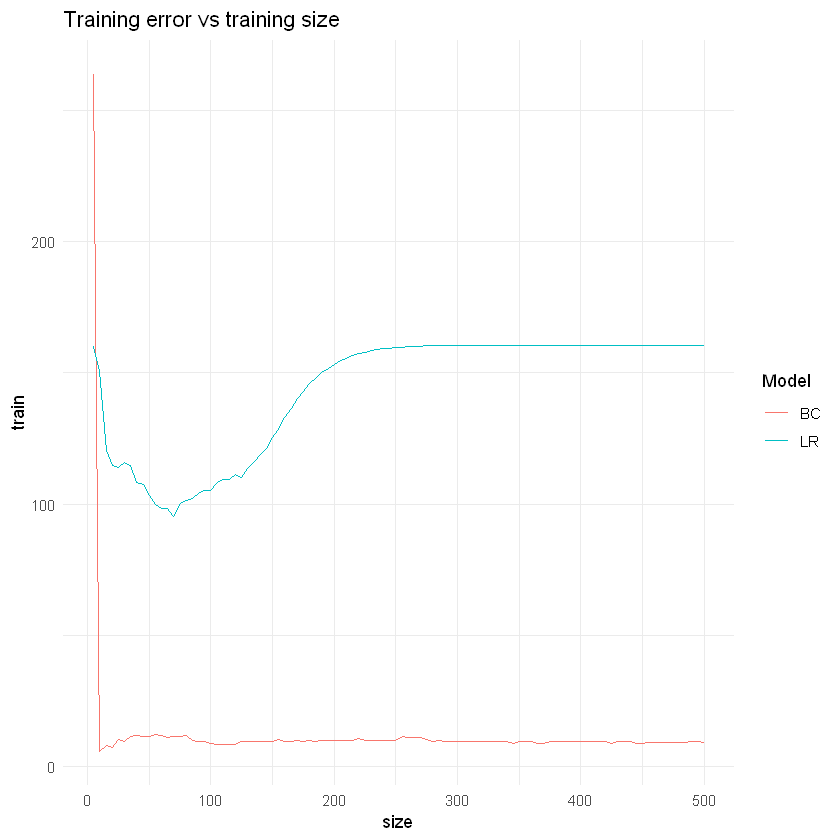

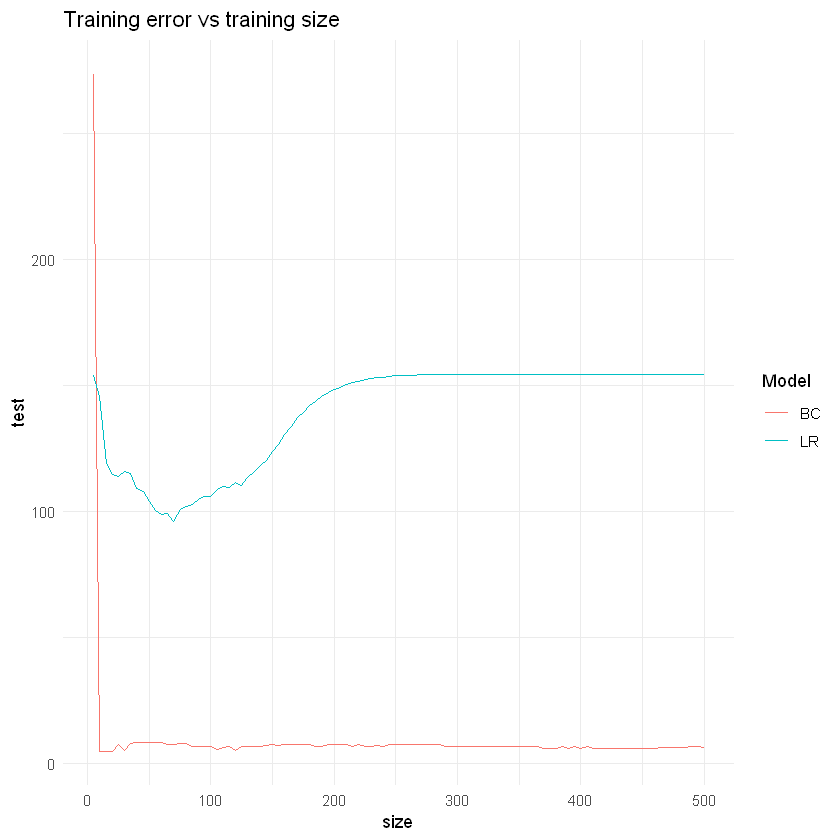

In [73]:
# plot training error vs trainning size for the two model
ggplot(data = model_error, aes(x = size, y = train, color = type)) + geom_line() + 
scale_color_discrete(guide = guide_legend(title = 'Model'))+
ggtitle('Training error vs training size')+
theme_minimal()

# plot testing error vs testing size for the two model
ggplot(data = model_error, aes(x = size, y = test, color = type)) + geom_line() + 
scale_color_discrete(guide = guide_legend(title = 'Model'))+
ggtitle('Training error vs training size')+
theme_minimal()

### 3. Explain observations in plots

1. What does happen for each classifier when the number of training data points is increased?

For the bayesian classifier, as training data points increase, training and testing errors decrease by a large amount. Nearly all data was classified correctly at a relatively large training size. Indicates, an increase in training data size improves the performance of bayesian classifier.

For the logistic regression, as training data points increase, training and testing errors tend to decrease but then increase when training size become too large. This may due to the fact that the model is overfitting the training data. As training size increase, the model become more complex.
 
2. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

Based on the plot,  the Bayesian classifier out performs logistic regression in all training size. In this case, Bayesian classifier is the best for both scenario but in other datasets it might not be the case, this will be further explained in the next question.


3. Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons.

Bayesian classifier is a classifier that is less likely to overfit compare to logistic regression because it is a generative model that models the joint distribution, where logistic regression is a discriminative model that directly models the posterior probability. As Bayesian classifier has a simple hypothesis function, the model has a high bias, where logistic regression has a low bias and vice versa for variance. This also means that Bayesian classifier is suitable for small data size and logistic regression is suitable for larger data size. If the training size is small, there will not be enough data point for logistic regression to converge. In this case, the training data size is 500 at maximum which is still relatively small in real world situations, this may explains the poor performance of logistic regression.

On the other hand, Bayesian classifier assumes all the features to be conditionally independent, in this case the predictions are accurate may caused by the fact that this assumption is true. Otherwise, the predictions would be poor. 